## Merge file 

In [1]:
import csv
import pandas as pd 

# Generate filenames programmatically
files = ["stat22/22_new_final_balance_{}.csv".format(i) for i in range(50,150)]

merged_filename = "22stat_merge_result.csv"

with open(merged_filename, 'w', newline='') as outfile:
    writer = csv.writer(outfile)
    
    for index, filename in enumerate(files):
        with open(filename, 'r') as infile:
            reader = csv.reader(infile)
            
            # Skip header only if it's not the first file
            if index != 0:
                next(reader, None)
                
            # Write rows from current file to the output file
            writer.writerows(reader)

## Find average of each betting agents. 

In [2]:
import pandas as pd

# Read the data
df = pd.read_csv("22stat_merge_result.csv", header=None)

# Drop the header row
df = df.drop(0)

# Convert all values to float
df = df.astype(float)

# Define ranges for mapping
ranges = [
    (0, 5, 1),
    (5, 10, 2),
    (10, 15, 3),
    (15, 20, 4),
    (20, 25, 5),
    (25, 30, 6),
    (30, 35, 7)
]

# Create a mapping function based on ranges
def get_mapping(col):
    for start, end, category in ranges:
        if start <= col < end:
            return category

# Create a new DataFrame with mapped columns
mapped_df = df.copy()
mapped_df.columns = [get_mapping(col) for col in df.columns]

# Group by column categories and compute the mean
averaged_df = mapped_df.groupby(mapped_df.columns, axis=1).mean()
averaged_df = averaged_df - 100000000

print(averaged_df)


               1            2          3           4          5           6  \
1   -1148.700000  4246.500000  -0.600000 -284.700000  80.400000  -22.200000   
2    -225.000000   331.561941 -17.100000 -292.289799  68.996989 -524.940547   
3    -120.112839  1755.136809 -40.889721  -39.000000  71.830969 -177.142597   
4    -501.000000   389.364569 -17.499462  -17.700000  15.000000 -234.447049   
5    -318.130884  1945.530107 -99.803563 -135.423605  60.850826  180.003585   
..           ...          ...        ...         ...        ...         ...   
96   -997.338736  1708.071799  -8.223467  112.615245  29.101849 -286.588875   
97   -136.609172   140.733020   2.200000  -26.021996   3.600000 -146.937107   
98   -219.000000  -329.764805 -22.500000 -118.051502   9.000000 -101.996997   
99   -288.517917   221.955838 -24.748896  -38.555520  16.648896 -276.671043   
100  -267.750000   290.400000   0.000000    2.400000  12.600000 -188.850000   

               7  
1   -2870.700000  
2     658.771

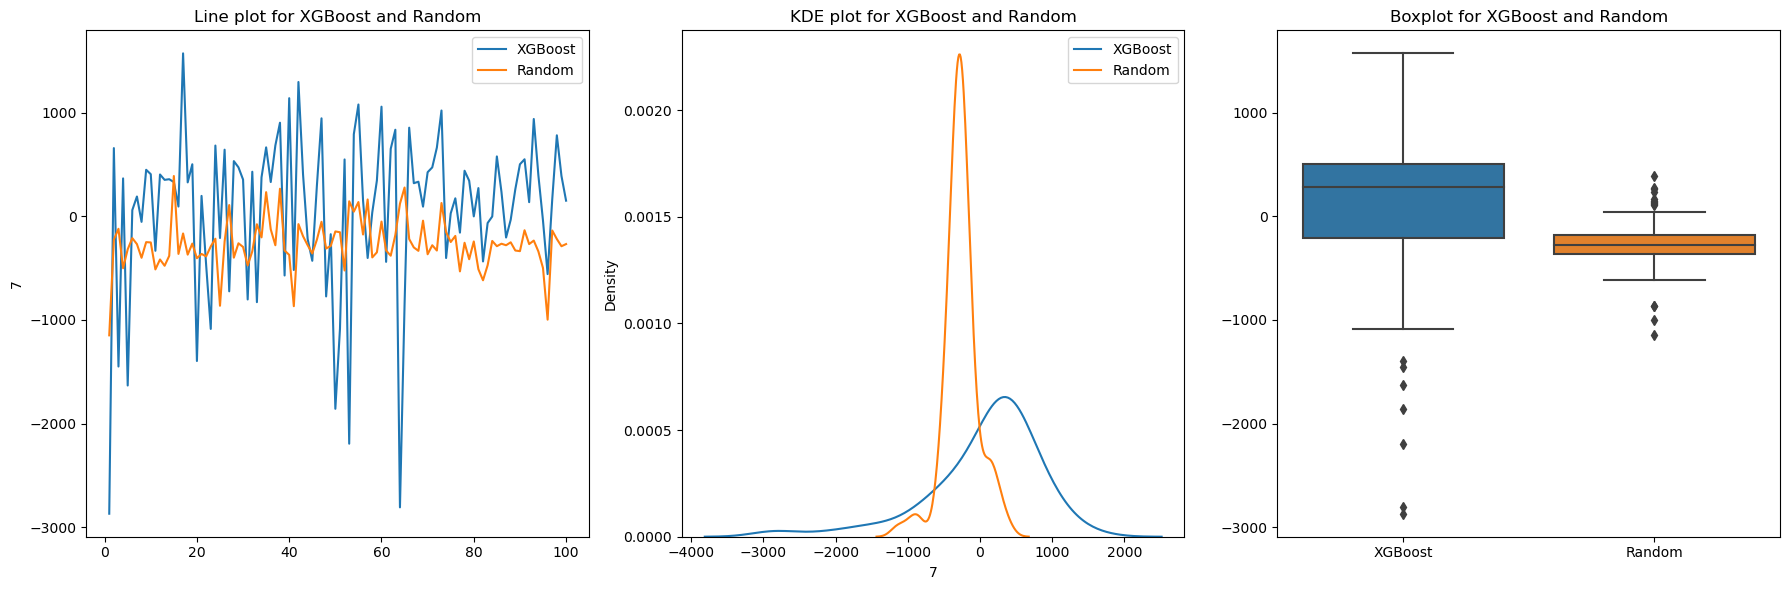

P_value_xgboost 3.545377467162325e-07
P_value_Random 1.2904227332910523e-05
not normal
There is a statistically significant difference
P-Value 2.296344484545147e-09



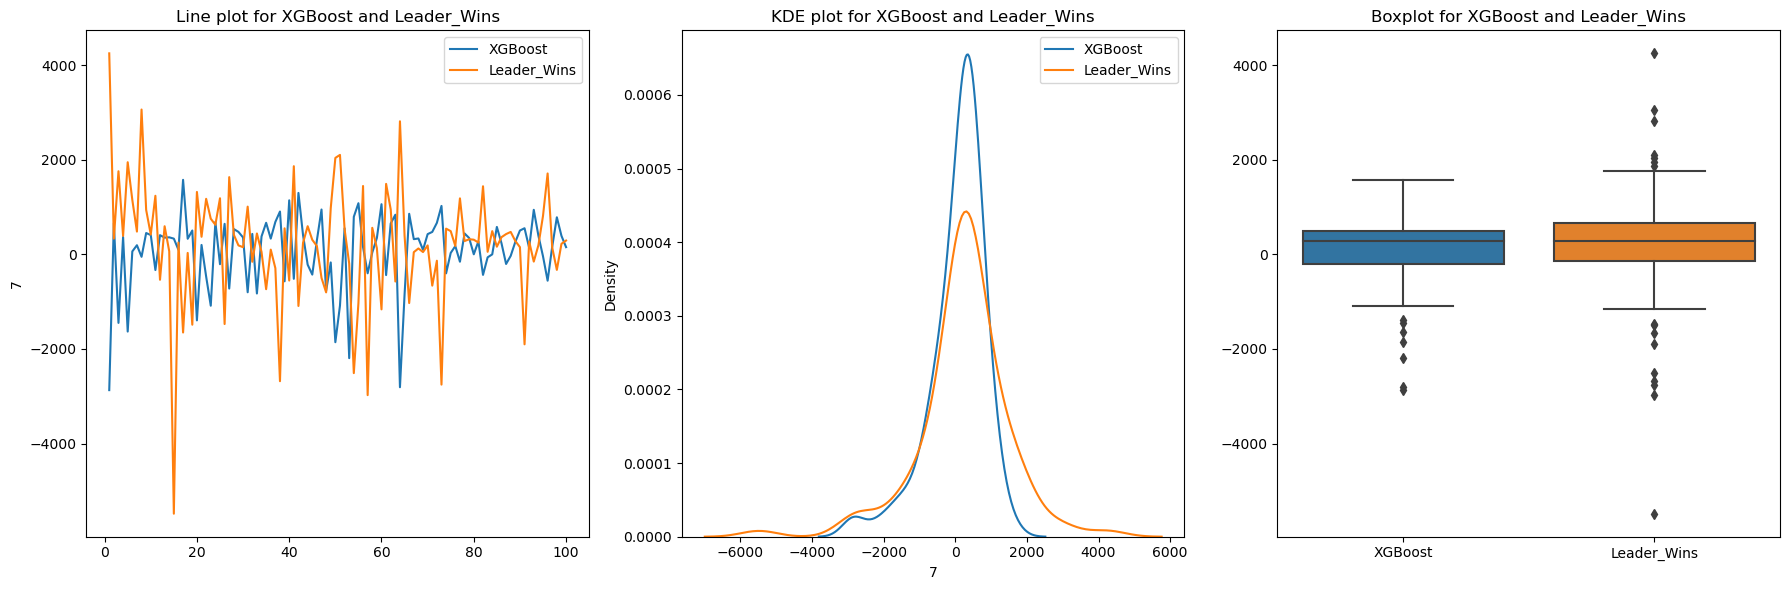

P_value_xgboost 3.545377467162325e-07
P_value_Leader_Wins 1.8999996882484993e-06
not normal
There isn't a statistically significant difference


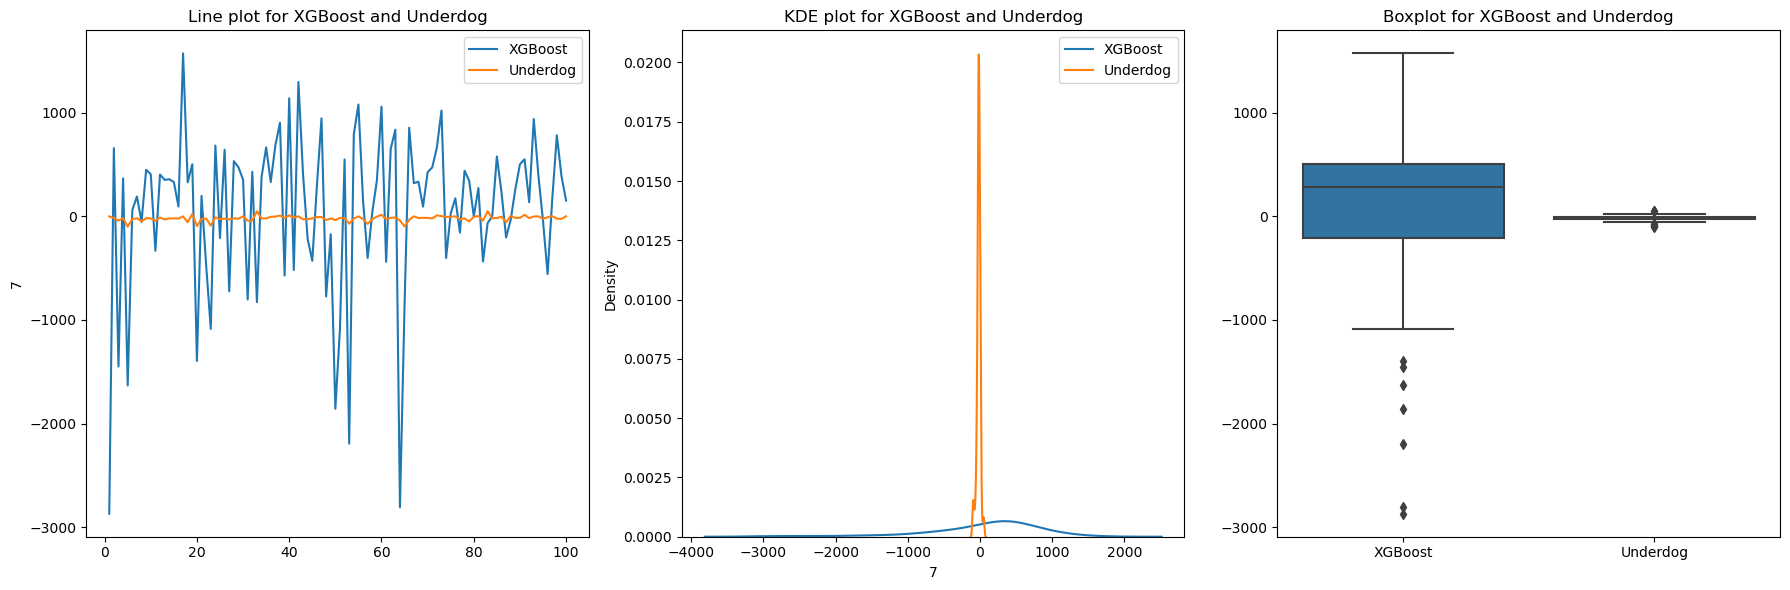

P_value_xgboost 3.545377467162325e-07
P_value_Underdog 4.188828825135715e-06
not normal
There is a statistically significant difference
P-Value 3.2861142245052315e-05



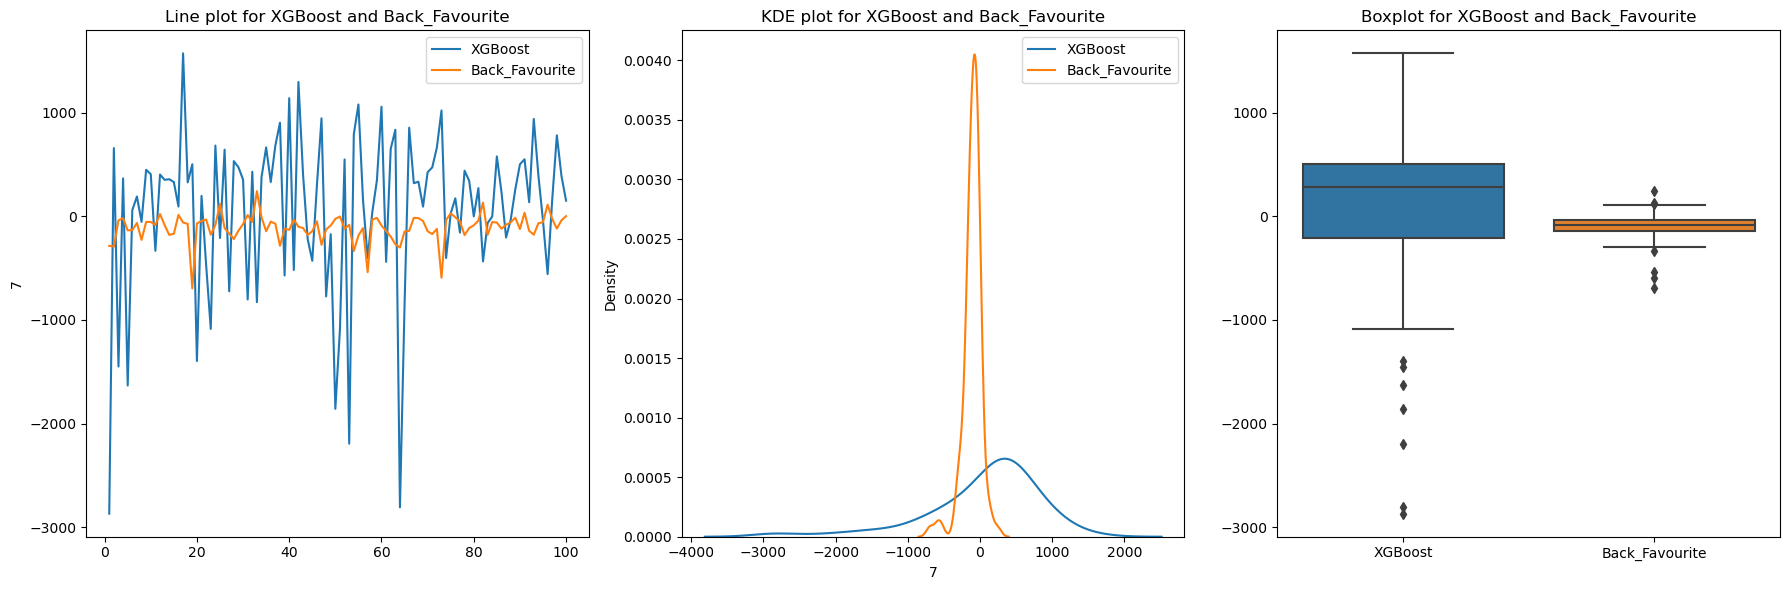

P_value_xgboost 3.545377467162325e-07
P_value_Back_Favourite 2.100184381959025e-08
not normal
There is a statistically significant difference
P-Value 6.742648847195683e-07



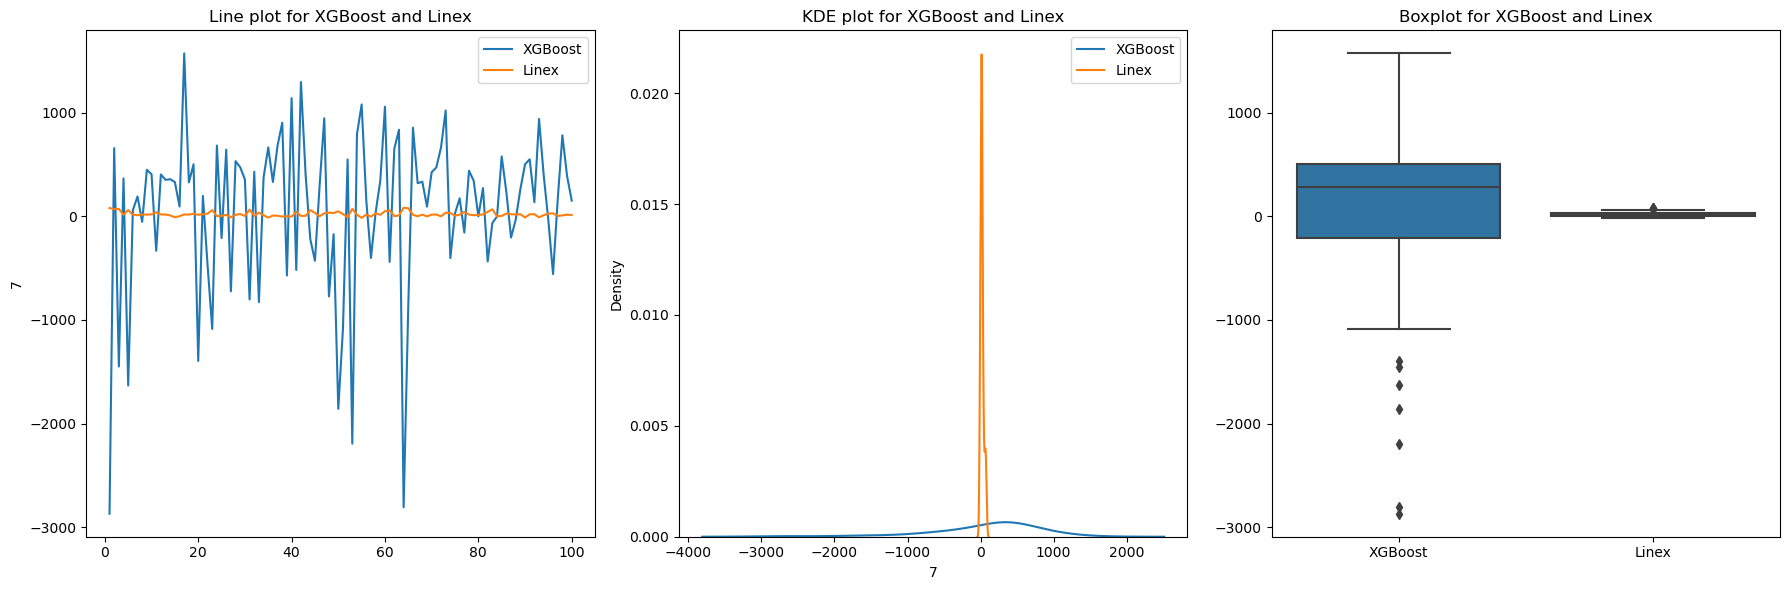

P_value_xgboost 3.545377467162325e-07
P_value_Linex 3.411211991988239e-06
not normal
There is a statistically significant difference
P-Value 0.00034251054422058236



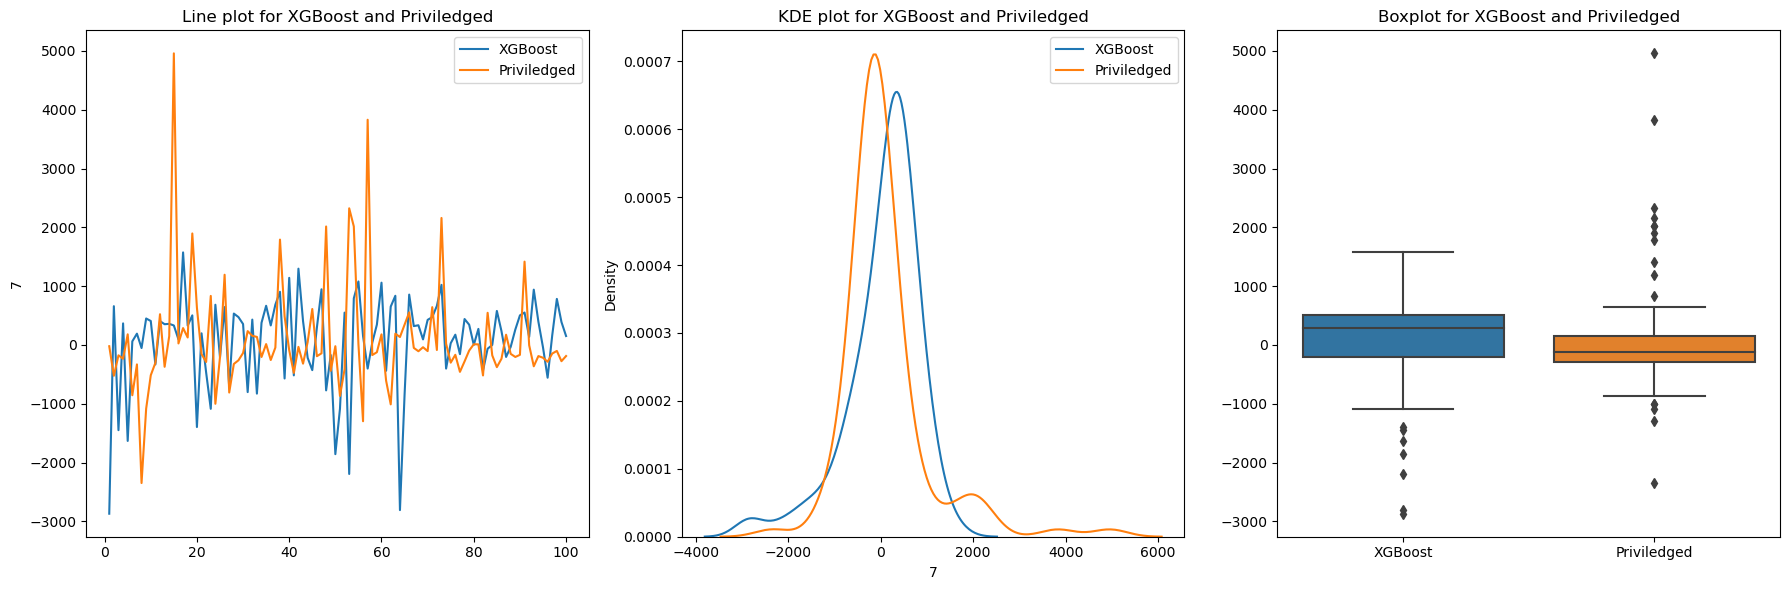

P_value_xgboost 3.545377467162325e-07
P_value_Priviledged 7.263824524511575e-12
not normal
There is a statistically significant difference
P-Value 0.006909675588339155



In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

xgboost_avg_balance = averaged_df.iloc[:, 6]  # XGBoost column

# Define agent names for easier access and readability
agent_names = ["Random", "Leader_Wins", "Underdog", "Back_Favourite", "Linex", "Priviledged"]

# Loop through columns 1-6 for other agents
for col_index in range(6):
    other_agent_balance = averaged_df.iloc[:, col_index]
    agent_name = agent_names[col_index]

    # Group the plots horizontally
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Line plot for XGBoost and the other agent
    sns.lineplot(data=xgboost_avg_balance, ax=axes[0], label='XGBoost')
    sns.lineplot(data=other_agent_balance, ax=axes[0], label=agent_name)
    axes[0].set_title(f'Line plot for XGBoost and {agent_name}')
    axes[0].legend()

    # KDE plot for the distributions
    sns.kdeplot(xgboost_avg_balance, ax=axes[1], label='XGBoost')
    sns.kdeplot(other_agent_balance, ax=axes[1], label=agent_name)
    axes[1].set_title(f'KDE plot for XGBoost and {agent_name}')
    axes[1].legend()

    # Boxplot for the two distributions
    combined_data = pd.concat([xgboost_avg_balance.rename('XGBoost'), 
                               other_agent_balance.rename(agent_name)], axis=1)
    sns.boxplot(data=combined_data, ax=axes[2])
    axes[2].set_title(f'Boxplot for XGBoost and {agent_name}')
    
    plt.tight_layout()
    plt.show()

    # Check normality for both columns
    _, pvalue_xgboost = stats.shapiro(xgboost_avg_balance)
    _, pvalue_other_agent = stats.shapiro(other_agent_balance)
    print("P_value_xgboost", pvalue_xgboost)
    print(f"P_value_{agent_name}", pvalue_other_agent)

    # If both are normally distributed
    if pvalue_xgboost > 0.05 and pvalue_other_agent > 0.05:
        print("normal")
        statistic, pvalue = stats.ttest_ind(xgboost_avg_balance, other_agent_balance)
        if pvalue < 0.05:
            print("There is a statistically significant difference")
        else:
            print("There isn't a statistically significant difference")
    else:
        print("not normal")
        # If either or both are not normally distributed
        statistic, pvalue = stats.mannwhitneyu(xgboost_avg_balance, other_agent_balance)
        if pvalue < 0.05:
            print("There is a statistically significant difference")
            print("P-Value", pvalue)
            print("")
        else:
            print("There isn't a statistically significant difference")


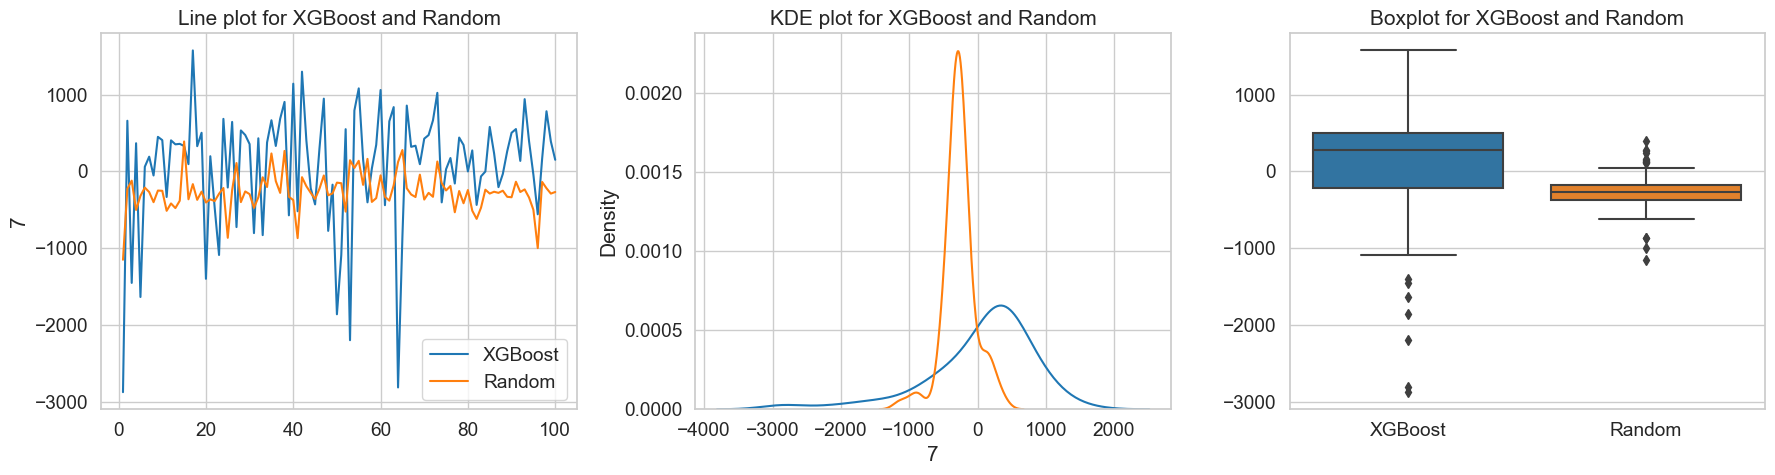

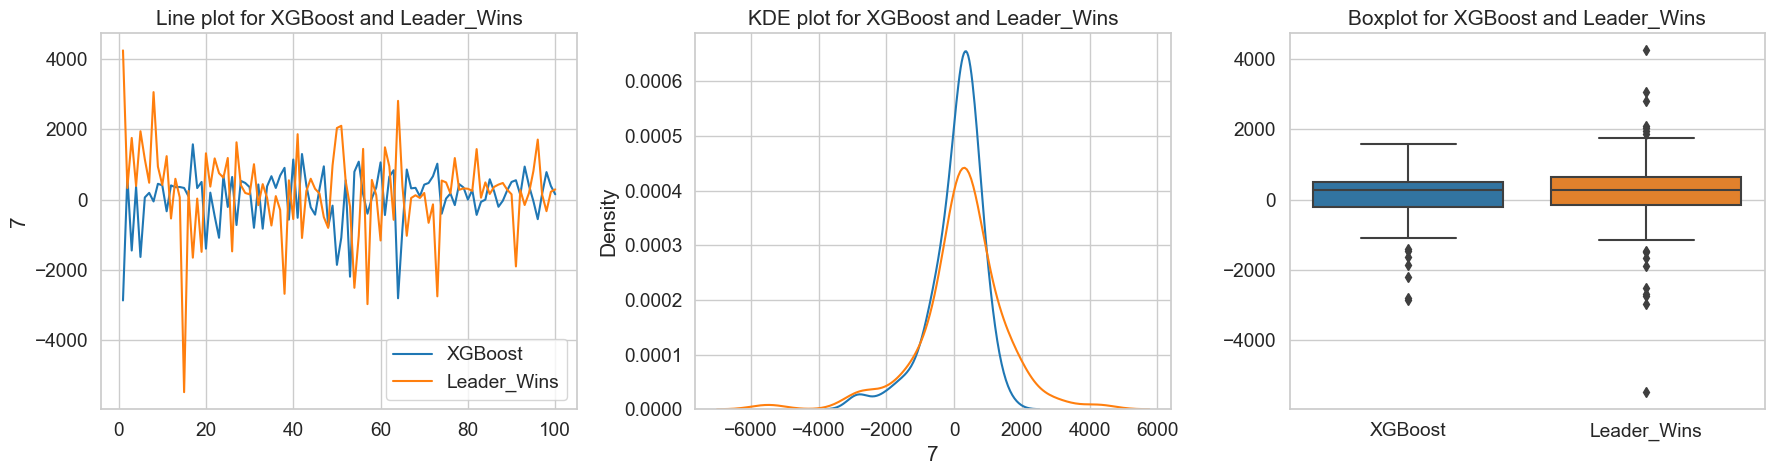

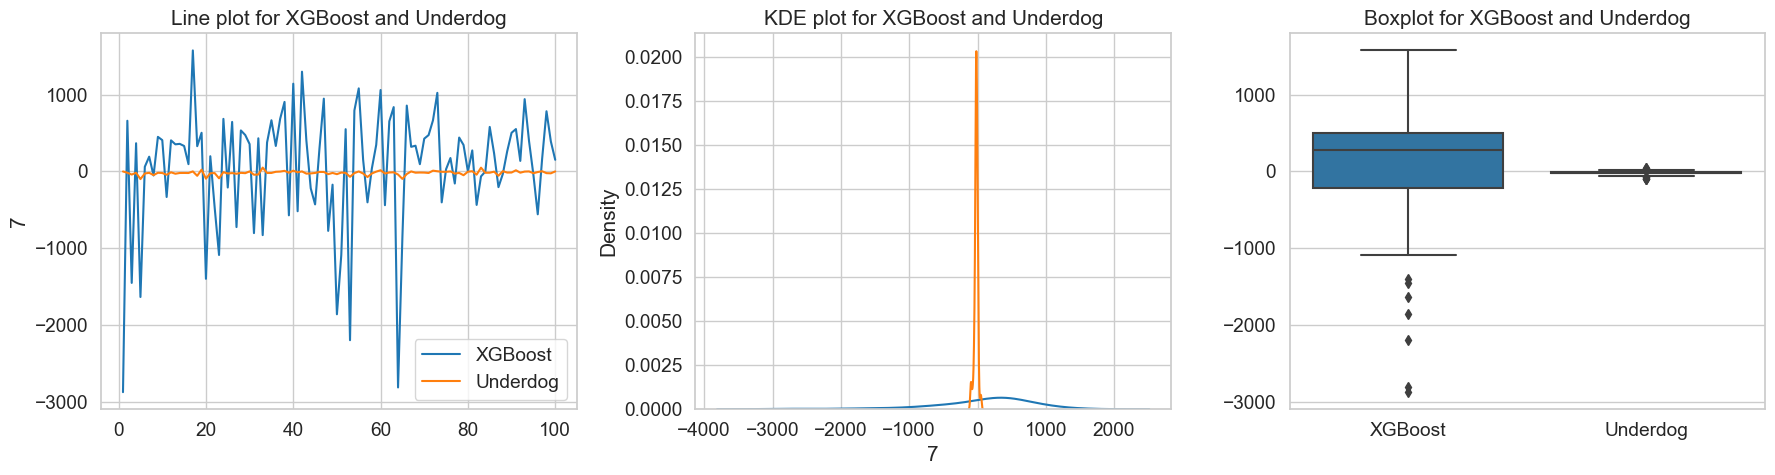

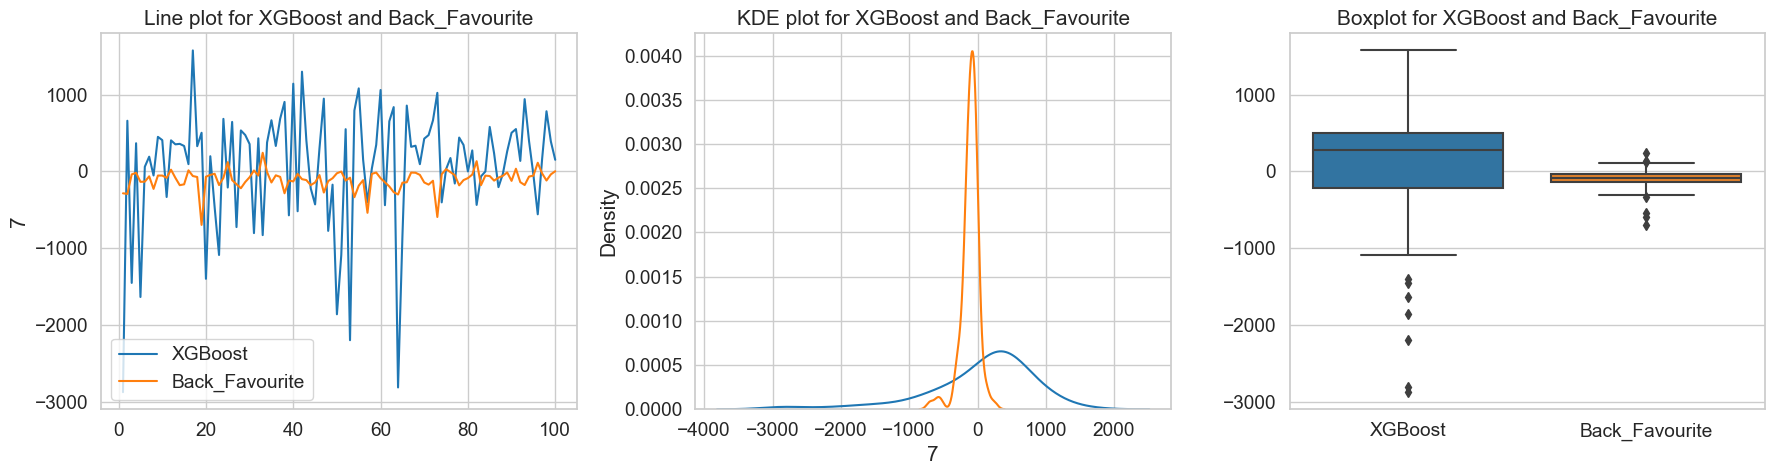

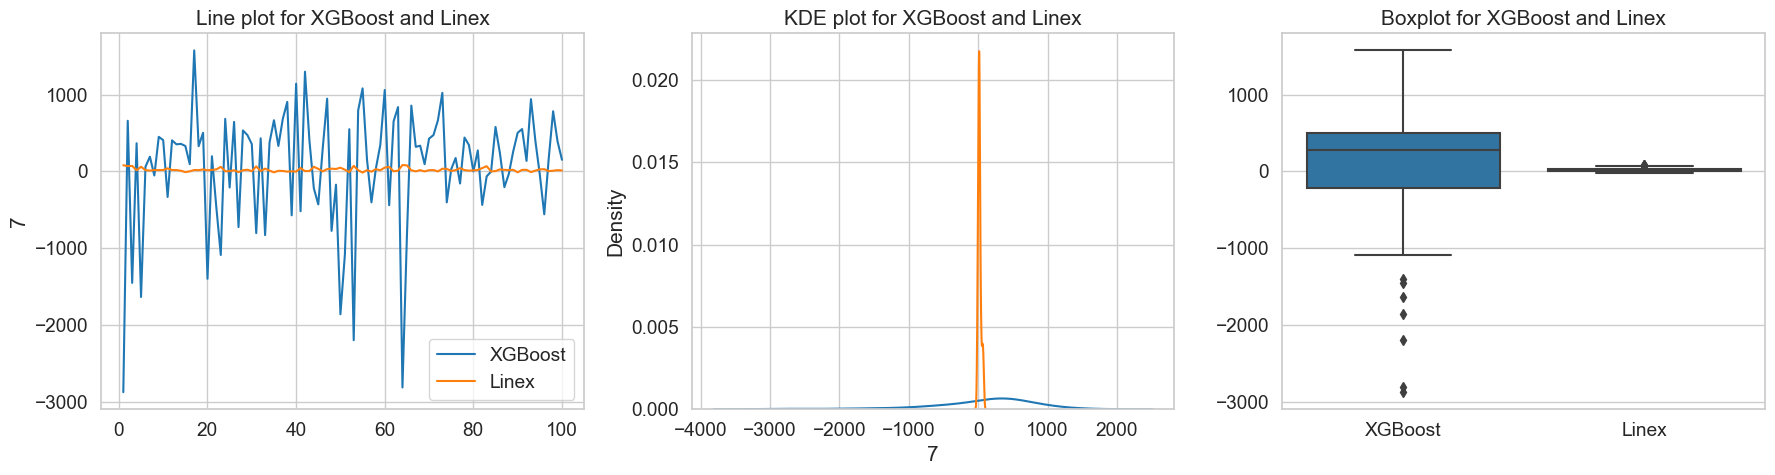

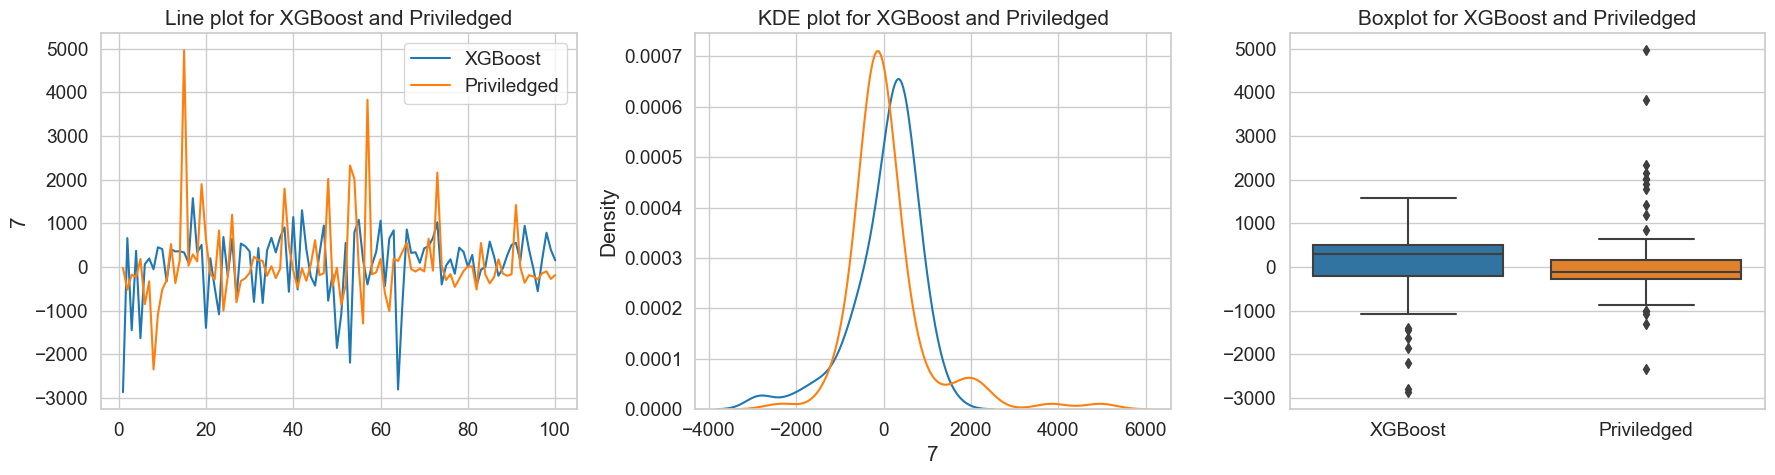

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

xgboost_avg_balance = averaged_df.iloc[:, 6]  # XGBoost column

# Define agent names for easier access and readability
agent_names = ["Random", "Leader_Wins", "Underdog", "Back_Favourite", "Linex", "Priviledged"]

# Setting style and text scale for seaborn plots
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.25)  # Adjust the font_scale to increase text size

# Loop through columns 1-6 for other agents
for col_index in range(6):
    other_agent_balance = averaged_df.iloc[:, col_index]
    agent_name = agent_names[col_index]

    # Group the plots horizontally with modified height
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # Decreased the height from 6 to 5

    # Line plot for XGBoost and the other agent
    sns.lineplot(data=xgboost_avg_balance, ax=axes[0], label='XGBoost')
    sns.lineplot(data=other_agent_balance, ax=axes[0], label=agent_name)
    axes[0].set_title(f'Line plot for XGBoost and {agent_name}')

    # KDE plot for the distributions
    sns.kdeplot(xgboost_avg_balance, ax=axes[1], label='XGBoost')
    sns.kdeplot(other_agent_balance, ax=axes[1], label=agent_name)
    axes[1].set_title(f'KDE plot for XGBoost and {agent_name}')

    # Boxplot for the two distributions
    combined_data = pd.concat([xgboost_avg_balance.rename('XGBoost'), 
                               other_agent_balance.rename(agent_name)], axis=1)
    sns.boxplot(data=combined_data, ax=axes[2])
    axes[2].set_title(f'Boxplot for XGBoost and {agent_name}')
    
    plt.tight_layout()
    plt.show()

    # Rest of your code...


# Plotting profit

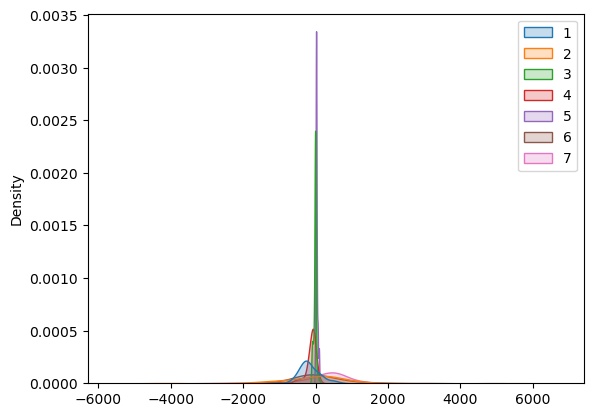

In [31]:
import seaborn as sns 
distributionPlot = sns.kdeplot(data=averaged_df,fill=True)

[Text(0, 0.5, 'Average Profit')]

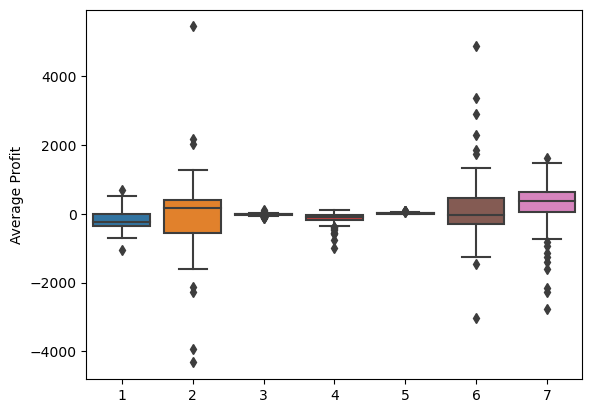

In [22]:
boxPlot = sns.boxplot(data=averaged_df)
boxPlot.set(ylabel='Average Profit')

In [19]:
def filter_quantiles(column):
    lower = column.quantile(0.05)
    upper = column.quantile(0.95)
    return column[(column >= lower) & (column <= upper)]

# Apply the function to each column
filtered_df = averaged_df.apply(filter_quantiles)
filtered_df = filtered_df.dropna()

print(filtered_df)

              1            2          3           4          5           6  \
3   -321.000000   590.721326  -2.846447  -38.400000   3.600000 -756.600000   
4   -105.000000   224.101193  -8.384221  -67.657790  17.352663 -595.136884   
6   -306.858328   -81.600000   5.701851  -68.400000  24.000000 -159.343523   
7   -357.517206   931.592867 -17.142141 -150.895197  56.657315 -181.084354   
10  -198.000000    36.300000  -0.300000  -13.500000  12.000000 -434.100000   
..          ...          ...        ...         ...        ...         ...   
95    47.361382 -1099.418655 -59.260790  -29.223800  35.135136  999.288416   
96  -282.600000    54.900000  -7.200000  -50.000000   7.200000 -160.300000   
97  -401.367196   810.009010 -40.906058 -145.088532  26.715810 -219.582305   
98  -153.000000  -450.715722  -8.400000  -74.099817  16.500000   -1.934369   
100 -264.892465  -667.949187 -18.428337 -227.437701   0.400089  375.989796   

              7  
3    524.525121  
4    534.725039  
6    586.

[Text(0, 0.5, 'Average Profit')]

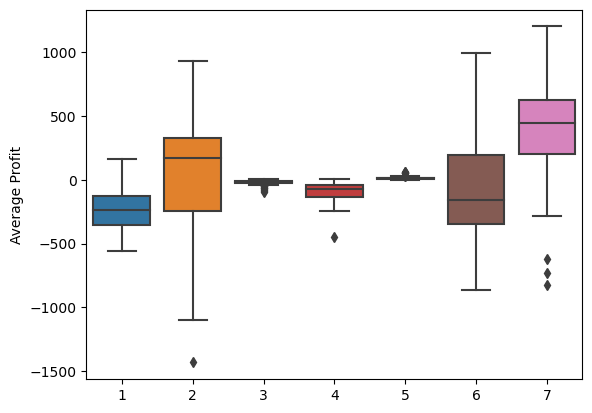

In [20]:
boxPlot = sns.boxplot(data=filtered_df)
boxPlot.set(ylabel='Average Profit')

## Statistical Testing

### Test Normal Distribution

In [23]:

from scipy import stats
for col in filtered_df.columns:
    statistic, pvalue = stats.shapiro(averaged_df[col])
    print(pvalue)
    if pvalue < 0.05:
        print("Condition " + "{:}".format(col) + 
              ". We can reject the null hypothesis (p=" + 
              "{:.30f}".format(pvalue) + 
              "). Therefore, data is not normally distributed.")
    else:
        print("Condition " + "{:}".format(col) + 
              ". We cannot reject the null hypothesis (p=" + 
              "{:.30f}".format(pvalue) + 
              "). Therefore, data is normally distributed.")

0.02439226023852825
Condition 1. We can reject the null hypothesis (p=0.024392260238528251647949218750). Therefore, data is not normally distributed.
1.8001637513975766e-08
Condition 2. We can reject the null hypothesis (p=0.000000018001637513975765614305). Therefore, data is not normally distributed.
6.438928323859727e-08
Condition 3. We can reject the null hypothesis (p=0.000000064389283238597272429615). Therefore, data is not normally distributed.
1.2222930133309884e-11
Condition 4. We can reject the null hypothesis (p=0.000000000012222930133309883871). Therefore, data is not normally distributed.
1.7563317911140075e-08
Condition 5. We can reject the null hypothesis (p=0.000000017563317911140075011645). Therefore, data is not normally distributed.
3.3588178904864208e-09
Condition 6. We can reject the null hypothesis (p=0.000000003358817890486420765228). Therefore, data is not normally distributed.
8.439939591653456e-08
Condition 7. We can reject the null hypothesis (p=0.000000084399

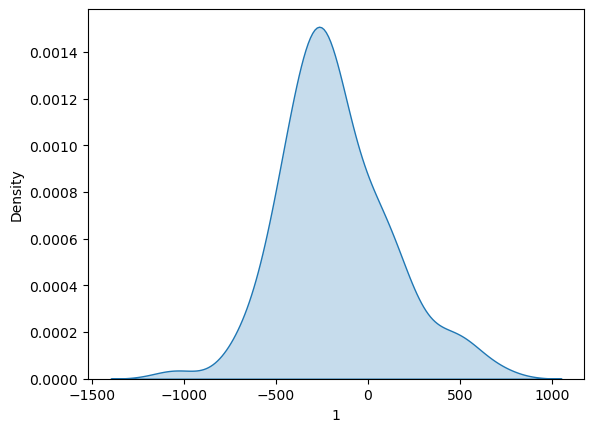

In [24]:
import seaborn as sns 
distributionPlot = sns.kdeplot(data=averaged_df[1],fill=True)

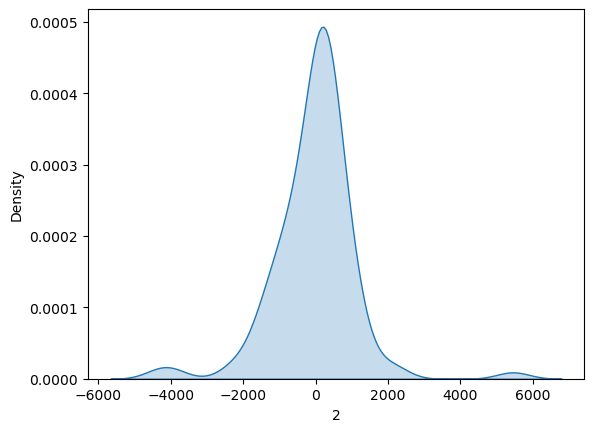

In [25]:
import seaborn as sns 
distributionPlot = sns.kdeplot(data=averaged_df[2],fill=True)

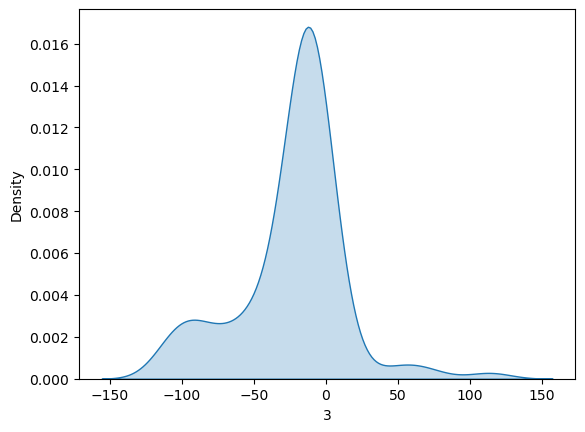

In [26]:
import seaborn as sns 
distributionPlot = sns.kdeplot(data=averaged_df[3],fill=True)

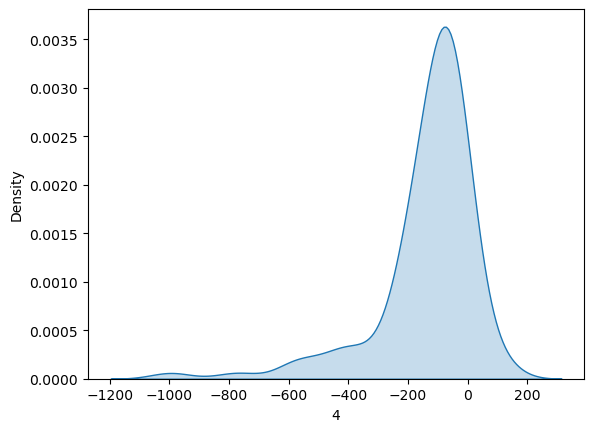

In [27]:
import seaborn as sns 
distributionPlot = sns.kdeplot(data=averaged_df[4],fill=True)

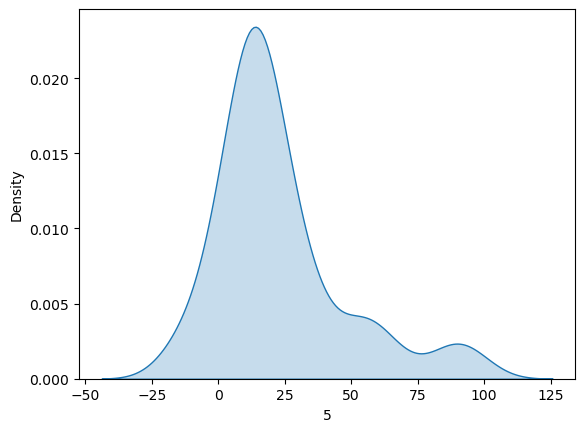

In [28]:
import seaborn as sns 
distributionPlot = sns.kdeplot(data=averaged_df[5],fill=True)

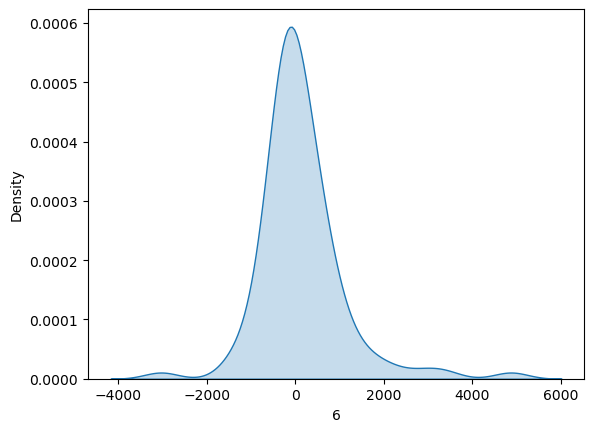

In [29]:
import seaborn as sns 
distributionPlot = sns.kdeplot(data=averaged_df[6],fill=True)

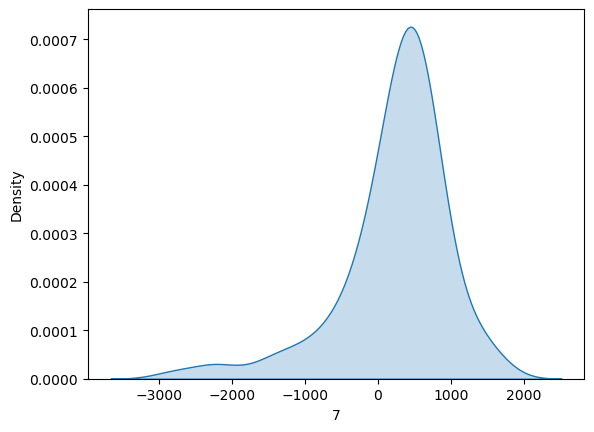

In [30]:
import seaborn as sns 
distributionPlot = sns.kdeplot(data=averaged_df[7],fill=True)